In [17]:
import tqdm
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt

from ase.io import read

from edpyt.espace import build_espace
from edpyt.espace import screen_espace
from edpyt.gf2_lanczos import build_gf2_lanczos
from edpyt.cotunneling import get_active_neig
from edpyt.shared import params
from edpyt.gf_lanczos import build_gf_lanczos

In [12]:
path = Path('../output/lowdin/')
H_eff = np.load(path/'effective_hamiltonian.npy')
nimp = H_eff.shape[0]

In [4]:
atoms = read('../dft/device/scatt.xyz')
atoms = atoms[np.isin(atoms.symbols,['C','N'])]
atoms

Atoms(symbols='NC7N', pbc=True, cell=[34.9383156615, 14.7643896, 15.34360374])

In [11]:
occupancy_goal = np.load(path/'occupancies_gfp.npy')
de = 0.01
mu=1e-3
energies = np.arange(-2, 2 + de / 2.0, de).round(7)
eta = 5e-3
z = energies + eta*1.j
beta = 1000.
idx0 = np.searchsorted(energies, mu)
energies[idx0-1], energies[idx0]

(0.0, 0.01)

In [ ]:
# hybrid = np.load('hybrid_real.npy')
# hyb0 = (hybrid[idx0-1] + hybrid[idx0]) / 2.

In [13]:
neig = get_active_neig(nimp, [(nimp//2,nimp//2)], 3)
neig = np.ones((nimp+1)*(nimp+1),int) * 4
neig

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [ ]:
espace, egs = build_espace(H_eff, np.zeros_like(H_eff), neig_sector=neig)
screen_espace(espace, egs, beta)
gf0 = build_gf2_lanczos(H_eff, np.zeros_like(H_eff), espace, beta, egs)
# TODO Look at implementing build_gf_lanczos here instead of build_gf2_lanczos


In [22]:
DOS0 = -1/np.pi * gf0(energies, eta).imag.trace(axis1=0,axis2=1)

In [27]:
gf0_test = np.array([np.linalg.inv(z[i]*np.eye(H_eff.shape[0])-H_eff) for i in range(z.size)])
DOS0_test = - 1/np.pi * gf0(energies, eta).imag.trace(axis1=0,axis2=1)

np.testing.assert_allclose(DOS0, DOS0_test)
np.allclose(DOS0, DOS0_test)

True

In [28]:
params['z'] = occupancy_goal
V = np.loadtxt('../output/lowdin/U_matrix.txt')
DC = np.diag(V.diagonal()*(occupancy_goal-0.5))

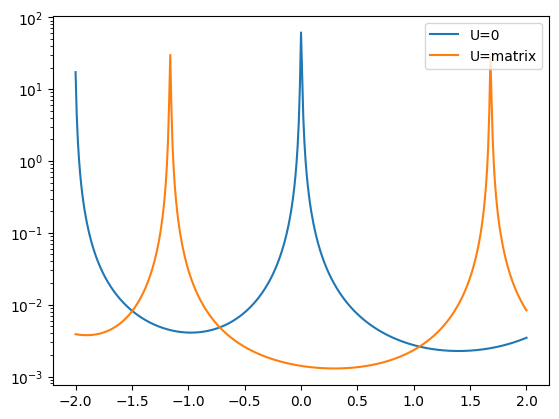

In [34]:
espace, egs = build_espace(H_eff-DC, V, neig_sector=neig)
screen_espace(espace, egs, beta)
gf = build_gf2_lanczos(H_eff-DC, V, espace, beta, egs)
DOS = -1/np.pi * gf(energies, eta).imag.trace(axis1=0,axis2=1)

plt.plot(energies, DOS0, label="U=0")
plt.plot(energies, DOS, label="U=matrix")
plt.legend()
plt.yscale('log')
plt.show()

In [33]:
class Sigma:

    def __init__(self, gf0, gf, eta=1e-5):
        self.gf0 = gf0
        self.gf = gf
        self.eta = eta

    def retarded(self, energy):
        energies = np.atleast_1d(energy)
        g0 = self.gf0(energies, self.eta)
        g = self.gf(energies, self.eta)
        sigma = np.empty((energies.size,gf.n,gf.n), complex)
        for e, energy in enumerate(tqdm.tqdm(energies)):
            sigma[e] = np.linalg.inv(g0[...,e]) - np.linalg.inv(g[...,e])
        return sigma


sigma = Sigma(gf0, gf, 1e-5)
sig = sigma.retarded(energies)
np.save('../output/lowdin/ed/ed_sigma.npy', sig)


100%|██████████| 401/401 [00:00<00:00, 11162.69it/s]
